# Pandas loading and data cleaning

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

from itertools import combinations
from scipy.stats import ttest_ind

sns.set(style="darkgrid")
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('main_task.csv')

Adding external data 

In [3]:
# Cities created by MaxMind, available from http://www.maxmind.com/
cities = pd.read_csv('worldcitiespop.csv')
cities.sample(5)

,Country,City,AccentCity,Region,Population,Latitude,Longitude
2677474,sy,qadmus,Qadmus,14,NaN,35.083333,36.166667
660509,co,buenavista,Buenavista,2,NaN,6.909444,-76.034722
1107933,ht,gros mangle,Gros Mangle,11,NaN,18.933333,-73.116667
1429666,ir,jabrani-ye bala,Jabrani-ye Bala,22,NaN,27.852100,51.802500
2253360,pl,geigenau,Geigenau,85,NaN,53.782450,22.689319


In [4]:
# list of positive words
df_pos_words = pd.read_csv('positive_words.txt',skiprows=34, names=['word'])
pos_words_list = df_pos_words['word'].to_list()

## Dataset Features:

- City: name of city
- Cuisine Style: type of cuisine
- Ranking: Restaurant rank realting ot other restaurants in that city
- Price Range: prices in the restaurant in three catogories
- Number of Reviews: total number of reviews
- Reviews: two last reviews with dates of reviews
- URL_TA: website of the restaurant at 'www.tripadvisor.com'
- ID_TA: ID of the restaurant at TripAdvisor
- Rating: restaurant rating

NaNs for every column in the set

In [5]:
for col in df.columns:
    print(col, str(round(100 * df[col].isnull().sum() / len(df), 2)) + '%')

Restaurant_id 0.0%
City 0.0%
Cuisine Style 23.21%
Ranking 0.0%
Rating 0.0%
Price Range 34.72%
Number of Reviews 6.36%
Reviews 0.0%
URL_TA 0.0%
ID_TA 0.0%


In [6]:
# changing name of columns for convinience
df = df.rename(
    columns={
        "Restaurant_id": "rest_id",
        "City": "city",
        "Cuisine Style": "cuisine_style",
        "Price Range": "price_range",
        "Reviews": "reviews",
        "Ranking": "ranking",
        "Rating": "rating",
        "Number of Reviews": "num_of_reviews"
    })

In [7]:
df.sample(5)

,rest_id,city,cuisine_style,ranking,rating,price_range,num_of_reviews,reviews,URL_TA,ID_TA
38625,id_2537,Paris,"['French', 'European']",2538.0,4.0,$,92.0,"[['Better Late Than Never', 'Taking and giving...",/Restaurant_Review-g187147-d4089279-Reviews-Fo...,d4089279
551,id_1639,Berlin,"['Cafe', 'European', 'Vegetarian Friendly', 'V...",1641.0,4.0,$,64.0,"[['Nice cafe', 'Very nice breakfast'], ['12/26...",/Restaurant_Review-g187323-d6494498-Reviews-Be...,d6494498
11214,id_3023,Paris,"['French', 'Cafe', 'Barbecue', 'Contemporary',...",3024.0,5.0,$$ - $$$,17.0,"[['awesome experience', 'Really good'], ['12/1...",/Restaurant_Review-g187147-d12242250-Reviews-B...,d12242250
18856,id_2281,Prague,['Cafe'],2286.0,4.5,NaN,2.0,"[['Good Food'], ['01/28/2017']]",/Restaurant_Review-g274707-d7124492-Reviews-Mo...,d7124492
9071,id_557,Madrid,"['Mediterranean', 'Spanish', 'Grill']",558.0,4.5,$$ - $$$,200.0,"[['A beautiful authentic spanish restaurant', ...",/Restaurant_Review-g187514-d3609685-Reviews-Ca...,d3609685


## EDA

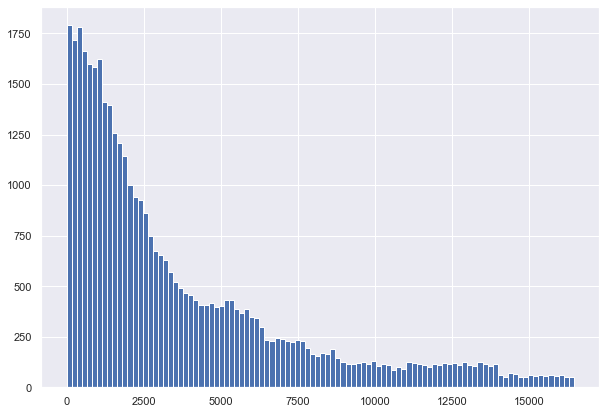

In [8]:
plt.rcParams['figure.figsize'] = (10, 7)
df['ranking'].hist(bins=100)

There are many restaurants with low rank, less then 3000

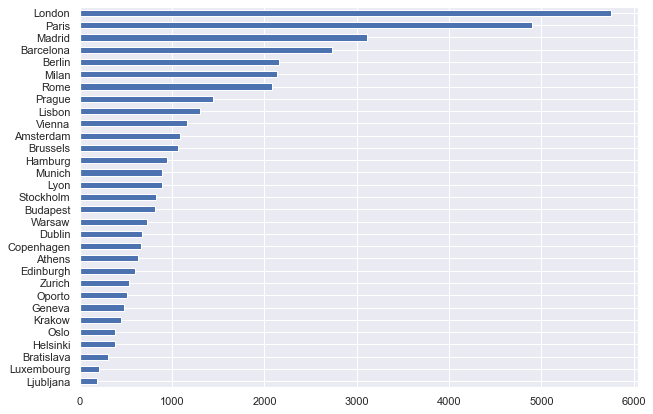

In [9]:
df['city'].value_counts(ascending=True).plot(kind='barh')

The biggest amount of restaurants in London

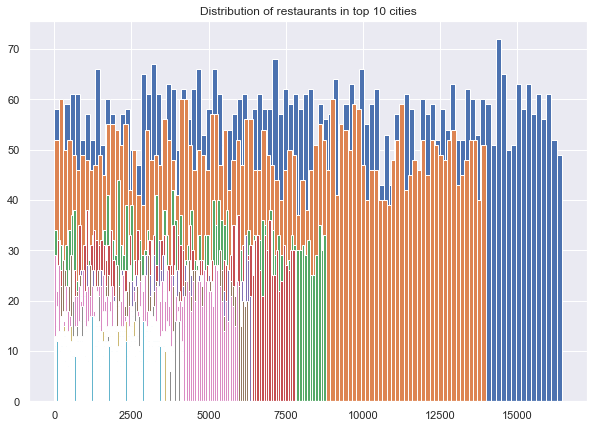

In [10]:
for x in (df['city'].value_counts())[0:10].index:
    df['ranking'][df['city'] == x].hist(bins=100)
plt.title('Distribution of restaurants in top 10 cities')
plt.show()

Ranking has a normal distribution. Th shift is only dut to more restaurants in big cities.

It makes sense to create a new feature which put all rankings to the same common value.

Checking the distribution of target value vs rank of the restaurant

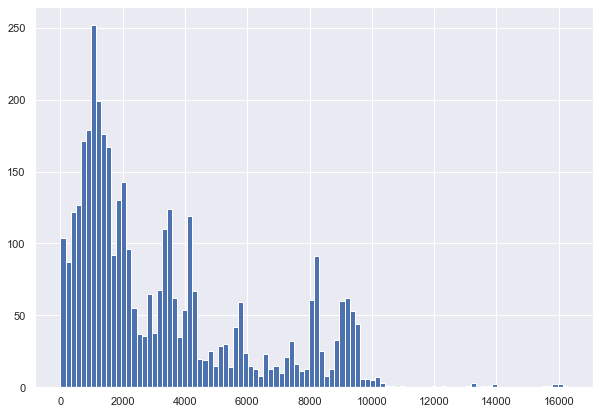

In [11]:
df['ranking'][df['rating'] == 5].hist(bins=100)

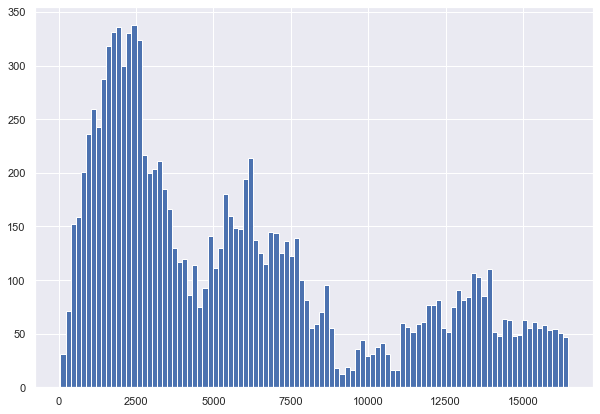

In [12]:
df['ranking'][df['rating'] < 4].hist(bins=100)

Distribution is assymetrical, rigth shifted. Mostly ranking is lower then 4000 

Correlative analysis

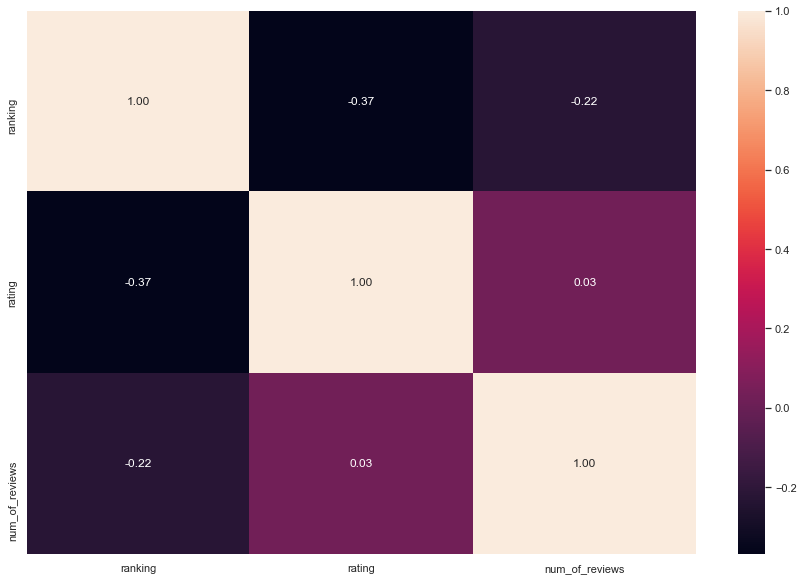

In [13]:
sns.set()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, ax=ax, fmt=".2f")

All features are correlated badly and will be used for model. It is also good to do correlation later, fater feature engineering

## Cleaning and Preparing Data

Functions

In [14]:
def reviews_date(rew, count): # function getting date from string
    date = re.findall(r'\d\d?/\d\d?/\d+', rew)
    if len(date) == 0:
        return np.nan
    if count == 1:
        return pd.to_datetime(date[0])
    elif len(date) == 2:
        return pd.to_datetime(date[1])
    else:
        return np.nan

#functions calculation of relative restaurant level among all city restaurants
def get_Weight_Rank_RK(row):
    Weight_Rank = row['ranking'] / row['restaurants_count']  
    return Weight_Rank 

def get_Weight_Rank(row):
    i=0
    city_min = CityMinMax[CityMinMax['city'] == row.city ]['min'].iloc[0]
    city_max = CityMinMax[CityMinMax['city'] == row.city ]['max'].iloc[0]
    Weight_Rank = round(1-(row['ranking'] - city_min)/(city_max - city_min),3)
    return Weight_Rank

def createWordList(line): # function to sreate a word list
    wordList2 =[]  
    wordList1 = line.split()  
    for word in wordList1:  
        cleanWord = ""  
        for char in word:   
            if char in '!,.?":;0123456789':  
                char = ""  
            cleanWord += char  
        wordList2.append(cleanWord.lower())  
    return wordList2 

def count_positive_words_proportion(rew):  # Amount of positive words if reviews   
    pos_words_count = 0  
    txts=re.findall(r'\w+\s*\w*\s*\w*', rew)  
    txt = ' '.join(txts)  
    #print(type(txt))  
    words = createWordList(txt) 
    
    words_count = len(words) if len(words) > 0 else 1 
    words_count = 1 
    
    pos_words_in_review=set(words).intersection(pos_words_list)  
    for word in words:  
        if word in pos_words_list:  
           #print(word)  
            pos_words_count +=1  
    return np.round(pos_words_count/words_count,2) 


def list_positive_words(rew): #List of unique positive words in reviews 
    txts=re.findall(r'\w+\s*\w*\s*\w*', rew)
    txt = ' '.join(txts)
    #print(type(txt))  
    words = createWordList(txt)
    words_count = len(words) if len(words) > 0 else 1  
    words_count = 1  
    pos_words_in_review=set(words).intersection(pos_words_list) 
        #print(len(pos_words_in_review))  
    if (len(pos_words_in_review) == 0):  
        return np.NAN  
    else:  
        return list(pos_words_in_review) 

In [15]:
# replacing of price range to more undestandable names and
# filling in NaNs to 2 as it is the most frequent

df['price_range'] = df['price_range'].replace({
    '$': 'low',
    '$$ - $$$': 'middle',
    '$$$$': 'high'
})

df['price_range'] = df['price_range'].fillna('middle')

In [16]:
# filling Nan
df['num_of_reviews_isNAN'] = pd.isna(df['num_of_reviews']).astype('uint8')

df['reviews_txt_NaN'] = pd.isna(df['reviews']).astype('uint8')

df['cuisine_style_NAN'] = pd.isna(df['cuisine_style']).astype('uint8') 

df['price_range_NAN'] = pd.isna(df['price_range']).astype('uint8')  

df['num_of_reviews'].fillna(0, inplace=True)
df['cuisine_style'] = df['cuisine_style'].fillna('unk')
df['reviews'] = df['reviews'].fillna('no review')

## Feature engineering

In [17]:
# creating a new column to show how many cuisines are in the restaurant, filling nan by 1
df['cuisine_count'] = df['cuisine_style'].str.findall(
    r'\w+\s*\w*\s*\w*').apply(lambda x: 1 if (x == 'unk') else len(x))

In [18]:
df['cuisine_count'].describe()

count    40000.000000
mean         2.622900
std          1.817602
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: cuisine_count, dtype: float64

In [19]:
# Amount of positive words in reviews
df['PositiveWords'] = df['reviews'].apply(lambda x: count_positive_words_proportion(x))
# List of unique positive words in reviews
df['PositiveWordsList'] = df['reviews'].apply(lambda x: list_positive_words(x))

In [20]:
df.sample(5)

,rest_id,city,cuisine_style,ranking,rating,price_range,num_of_reviews,reviews,URL_TA,ID_TA,num_of_reviews_isNAN,reviews_txt_NaN,cuisine_style_NAN,price_range_NAN,cuisine_count,PositiveWords,PositiveWordsList
27933,id_7528,Paris,"['French', 'European']",7529.0,4.0,middle,68.0,[['Visited twice . Dinner and brunch next day'...,/Restaurant_Review-g187147-d2230824-Reviews-Le...,d2230824,0,0,0,0,2,1.0,[good]
9021,id_7612,Paris,"['Bar', 'Pub']",7613.0,4.5,low,7.0,"[['Must Visit for Happy Hour Drinks'], ['12/20...",/Restaurant_Review-g187147-d11827928-Reviews-C...,d11827928,0,0,0,0,2,1.0,[happy]
34998,id_13723,Paris,unk,13725.0,2.0,middle,2.0,"[[], []]",/Restaurant_Review-g187147-d5813747-Reviews-Le...,d5813747,0,0,1,0,1,0.0,NaN
11985,id_1656,Munich,unk,1669.0,4.5,middle,4.0,"[['Nice local simple lunch'], ['04/18/2016']]",/Restaurant_Review-g187309-d10034042-Reviews-C...,d10034042,0,0,1,0,1,1.0,[nice]
7823,id_77,Vienna,"['German', 'Austrian', 'European', 'Central Eu...",78.0,4.0,middle,1066.0,"[['Good food and good fun', 'The Vienesse equi...",/Restaurant_Review-g190454-d1799525-Reviews-Re...,d1799525,0,0,0,0,5,3.0,"[good, fun]"


In [21]:
# working with dates from Reviews to create new feature on difference between the dates

df['date_first'] = df['reviews'].apply(lambda x: reviews_date(x, 1))
df['date_second'] = df['reviews'].apply(lambda x: reviews_date(x, 2))

df['rev_date_dif'] = df['date_first'] - df['date_second']

df['rev_date_dif'] = df['rev_date_dif'].fillna(df['rev_date_dif'].mean())

df['rev_date_dif'] = df['rev_date_dif'].apply(  # new column reflects how many days are between reviews
    lambda x: pd.to_timedelta(x).days)

In [22]:
# creating a new column which express the rating of restaurant based on mean rating for this city
df['ranking_city'] = 0
for item in df['city'].unique():
    cr_mean = df['ranking'].loc[df['city'] == item].mean()
    df['ranking_city'].loc[df['city'] == item] = cr_mean
df['ranking_city'] = df['ranking_city'] / df['ranking']

In [23]:
# making list of cities available at df with there population taking from cities
city_list = {}
for city in df.city.unique():
    city_list[city] = cities.Population[(cities.AccentCity == city) & (cities.Population.isnull() == False)].max() 

In [24]:
city_list

{'Paris': 2110694.0,
 'Stockholm': 1253309.0,
 'London': 7421228.0,
 'Berlin': 3398362.0,
 'Munich': 1246133.0,
 'Oporto': nan,
 'Milan': 1156903.0,
 'Bratislava': 423737.0,
 'Vienna': 1569315.0,
 'Rome': 2643736.0,
 'Barcelona': 1570378.0,
 'Madrid': 3102644.0,
 'Dublin': 1024027.0,
 'Brussels': 1019022.0,
 'Zurich': 346185.0,
 'Warsaw': 1651676.0,
 'Budapest': 1708088.0,
 'Copenhagen': 1089958.0,
 'Amsterdam': 745811.0,
 'Lyon': 463700.0,
 'Hamburg': 1733846.0,
 'Lisbon': 517798.0,
 'Prague': 1154508.0,
 'Oslo': 808690.0,
 'Helsinki': 558457.0,
 'Edinburgh': 435794.0,
 'Geneva': 181492.0,
 'Ljubljana': 255115.0,
 'Athens': 729139.0,
 'Luxembourg': nan,
 'Krakow': nan}

In [25]:
# there are 3 nan values which are filled using data from Google
city_list['Krakow'] = 766683
city_list['Luxembourg'] = 625978
city_list['Oporto'] = 1313000

In [ ]:
# making new column in df with population for each city
df['population'] = 0
for item in df['city'].unique():
    df['population'].loc[df['city'] == item] = city_list[item]

# new column reflects ratio between amount of population and rankig of the restaurant    
df['pop_ranking'] = df['population']/df['ranking']

# Amount of restaurants in each city
restaurants_in_city = df.groupby('city')['ranking'].count().to_dict()
df['restaurants_count'] = df['city'].map(restaurants_in_city)

# Amount of restaurants on 1000 humans for each city
df['restaurants_population'] = df['restaurants_count']/df['population']

# Weight of the restaurant amoung all other restaurants in the city
df['weight_rank'] = df.apply(lambda x: get_Weight_Rank_RK(x), axis=1)

CityMinMax = df.groupby('city')['ranking'].agg([min,max])
CityMinMax =CityMinMax.reset_index()
df['weight_rank_min_max'] = df.apply(lambda x: get_Weight_Rank(x), axis=1)

df.sample(5)

In [ ]:
# One-Hot Encoding - creating dummies from price range and city
for cat in ['price_range','city']:
    df = pd.concat([df, pd.get_dummies(df[cat], prefix=cat)], axis=1)
    df = df.drop([cat], axis=1)

In [ ]:
object_columns = [s for s in df.columns if df[s].dtypes == 'object']
df.drop(object_columns, axis=1, inplace=True)
df.drop(['date_first'], axis=1, inplace=True)
df.drop(['date_second'], axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
df.corr()

In [ ]:
# another correlative analysis wiht all features
sns.set()
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df.corr(), ax=ax, fmt=".2f")

We may see that all of fatures has low correlation with target value, except some new features like amount of population. 

# Split dataframe to two parts for model tarining and testing

In [ ]:
# Х - restaurants data, у - target variable (restaurants rating)
X = df.drop(['rating'], axis = 1)
y = df['rating']

In [ ]:
# import tools:
from sklearn.model_selection import train_test_split

In [ ]:
# "train" data is for model training, "test" - for model testing.
# Fo testing is used 25% of origin dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Create, train and test the model

In [ ]:
# libraries import
from sklearn.ensemble import RandomForestRegressor # tool for model training and testing
from sklearn import metrics # tool for evaluation of model

In [ ]:
# model creating
regr = RandomForestRegressor(n_estimators=100)

# model training on test data
regr.fit(X_train, y_train)

# using of trained model for predication of restaurants rating in test data.
# Predicted values put in y_pred
y_pred = regr.predict(X_test)

In [ ]:
# Compare predicted values (y_pred) with real (y_test), checking what is the medium difference
# Metrics called Mean Absolute Error (MAE) chows mean error for predicted values form real ones.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# lets see the most important features for the model
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')